In [7]:
from train import *

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

Current device: cuda


In [9]:
def lhs(size, lb=-1, rb=1):
    res = np.zeros(size)
    length = (rb - lb) / size
    for i in range(size):
        sub_lb = lb + length * i
        sub_rb = lb + length * (i + 1)
        res[i] = np.random.rand() * length + sub_lb
    return res
        

In [ ]:
epochs = 5000
lr = 0.01

# alpha = np.random.uniform(low=0.005/np.pi, high=0.1/np.pi, size=1000)
# print(alpha)
alpha = np.random.uniform(low=-1, high=1, size=100)
beta = np.random.uniform(low=-1, high=1, size=100)
# alpha = -0.752
# beta = 0.932
# print("Alpha: {:.3f}, Beta: {:.3f}".format(alpha, beta))
# print(alpha)
# print(beta)
# loss_i, loss_b, loss_f, loss, model, val_loss, val_ood_loss, nrmse = train(epochs=epochs, lr=lr, i_size=0, b_size=2, f_size=100, zero_shot=False, alpha_list=alpha, beta_list=beta, low=-1, high=1, eqname='poisson')
loss_i, loss_b, loss_f, loss, model, val_loss, val_ood_loss, nrmse, val_losses, val_ood_losses = train(epochs=epochs, lr=lr, i_size=0, b_size=2, f_size=1, zero_shot=True, alpha_list=alpha, beta_list=beta, low=-1, high=1, eqname='poisson', load=False, load_data='models/poisson_zs_8000.data')
# loss_i, loss_b, loss_f, loss, model, val_loss, val_ood_loss, nrmse, val_losses, val_ood_losses= train(epochs=epochs, lr=lr, i_size=1, b_size=2, f_size=1, zero_shot=True, alpha_list=alpha, low=-1, high=1, eqname='burgers')
# loss_i, loss_b, loss_f, loss, model, val_loss, val_ood_loss, nrmse = train(epochs=epochs, lr=lr, i_size=100, b_size=100, f_size=10000, zero_shot=False, alpha_list=(0.01 / np.pi), low=-1, high=1, eqname='burgers')

In [ ]:
# plt.plot(loss_i, label='loss_i')
plt.plot(loss_b, label='loss_b')
plt.plot(loss_f, label='loss_f')
plt.plot(loss, label='loss')
plt.yscale('log')
plt.legend()
plt.title('Zero-shot training losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:

# plt.plot(val_losses['loss_i'], label='loss_i')
plt.plot(val_losses['loss_b'], label='loss_b')
plt.plot(val_losses['loss_f'], label='loss_f')
plt.plot(val_losses['loss'], label='loss')
plt.yscale('log')
plt.legend()
plt.title('Zero-shot validation losses (in-distribution)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:

# plt.plot(val_losses['loss_i'], label='loss_i')
plt.plot(val_ood_losses['loss_b'], label='loss_b')
plt.plot(val_ood_losses['loss_f'], label='loss_f')
plt.plot(val_ood_losses['loss'], label='loss')
plt.yscale('log')
plt.legend()
plt.title('Zero-shot validation losses (out-of-distribution)')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
epochs = [5000 / len(val_loss) * i for i in range(1, len(val_loss) + 1)]
plt.plot(epochs, val_loss, label='in-distribution')
plt.plot(epochs, val_ood_loss, label='out-of-distribution')
plt.yscale('log')
plt.title("Validation metrics")
plt.xlabel('Epochs')
plt.ylabel('NRMSE')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

nrmse_df = pd.DataFrame(nrmse)
val_loss_df = pd.DataFrame(val_loss)
val_ood_loss_df = pd.DataFrame(val_ood_loss)
train_loss_df = pd.DataFrame({'loss_b': loss_b, 'loss_f': loss_f, 'loss': loss})

nrmse_df.to_csv('data/nrmse_burgers_zs.csv')
val_loss_df.to_csv('data/val_loss_burgers_zs.csv')
val_ood_loss_df.to_csv('data/val_ood_loss_burgers_zs.csv')
train_loss_df.to_csv('data/train_loss_burgers_zs.csv')

## Results - Case 1

In [ ]:
from maml import *

In [ ]:
alpha = -1.26
beta = 1.48

In [ ]:
loss_i, loss_b, loss_f, loss, model, val_loss, val_ood_loss, nrmse, val_losses, val_ood_losses = train(epochs=2000, lr=0.01, i_size=0, b_size=2, f_size=100, zero_shot=False, alpha_list=alpha, beta_list=beta, low=-1, high=1, eqname='poisson', load=False, load_data='models/poisson_zs_8000.data')

In [ ]:
model3 = PINN(20, 5, dim=1, param_num=2, zero_shot=True)
model3.load_state_dict(torch.load('models/poisson_zs_2000_ref.data'))
model3.to(device)
model2 = PINN(20, 5, dim=1, param_num=2, zero_shot=True)
model2.load_state_dict(torch.load('models/model_used/maml_poisson_high1_5000.data'))
model2.to(device)

In [ ]:
task = alpha, beta
maml = MAML(5, 0.01, 0.0005, 1,2,  1, -1, 1, eqname='poisson', zero_shot=True, load=False, modelpath='models/model_ref/burgers_zs_1000_ref.data')
phi, _, _, _, _, _, _ = maml._inner_loop(model2.state_dict(), task, train=True)
model_adapted = deepcopy(model2)
model_adapted.load_state_dict(phi)

In [ ]:
test_x = np.linspace(-1, 1, num=100).reshape(-1, 1)
test_alpha = np.full((100, 1), alpha)
test_beta = np.full((100, 1), beta)

X = test_x

Y = np.sin(test_alpha * X) + np.cos(test_beta * X) + 0.1 * X
test_in = np.hstack((test_x, test_alpha, test_beta))
test_in_ = test_x
test_u_ = model(torch.Tensor(test_in_).to(device))
test_u = model3(torch.Tensor(test_in).to(device))
# test_in = test_x
test_u_2 = model2(torch.Tensor(test_in).to(device))
test_u_3 = model_adapted(torch.Tensor(test_in).to(device))

In [ ]:
C_ = test_u_.cpu().detach().numpy()
C = test_u.cpu().detach().numpy()
C2 = test_u_2.cpu().detach().numpy()
C3 = test_u_3.cpu().detach().numpy()
plt.figure(figsize=(10, 8))
plt.plot(X, Y, 'k', label='truth')
plt.plot(X, C_, 'r--', label='PINN')
plt.plot(X, C, 'b--', label='zero-shot')
plt.plot(X, C2, 'g--', label='MAML')
plt.plot(X, C3, 'y--', label='adapted MAML')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Solutions (out-of-distribution)')
plt.legend()

In [ ]:
def compute_nrmse(C, Y):
    return np.sqrt(np.sum((C-Y)**2)/np.sum(C**2))

In [ ]:
compute_nrmse(C_, Y)

In [ ]:
nrmse_test_zs = []
nrmse_test_maml = []
nrmse_test_maml_adapted = []
nrmse_test_pinn = []

alpha_val = np.hstack((np.random.uniform(low=-1.5, high=-1, size=5), np.random.uniform(low=1, high=1.5, size=5)))
beta_val = np.hstack((np.random.uniform(low=-1.5, high=-1, size=5), np.random.uniform(low=1, high=1.5, size=5)))

for alpha, beta in zip(alpha_val, beta_val):
    loss_i, loss_b, loss_f, loss, model_, val_loss, val_ood_loss, nrmse, _, _ = train(epochs=1000, lr=0.01, i_size=0, b_size=2, f_size=100, zero_shot=False, alpha_list=alpha, beta_list=beta, low=-1, high=1, eqname='poisson')
    test_x = np.linspace(-1, 1, num=100).reshape(-1, 1)
    test_alpha = np.full((100, 1), alpha)
    test_beta = np.full((100, 1), beta)
    X = test_x
    Y = np.sin(test_alpha * X) + np.cos(test_beta * X) + 0.1 * X
    test_in = np.hstack((test_x, test_alpha, test_beta))
    test_u_ = model_(torch.Tensor(test_x).to(device))
    test_u = model3(torch.Tensor(test_in).to(device))
    test_u_2 = model2(torch.Tensor(test_in).to(device))
    test_u_3 = model_adapted(torch.Tensor(test_in).to(device))
    C_ = test_u_.cpu().detach().numpy()
    C = test_u.cpu().detach().numpy()
    C2 = test_u_2.cpu().detach().numpy()
    C3 = test_u_3.cpu().detach().numpy()
    nrmse_test_pinn.append(compute_nrmse(C_, Y))
    nrmse_test_zs.append(compute_nrmse(C, Y))
    nrmse_test_maml.append(compute_nrmse(C2, Y))
    nrmse_test_maml_adapted.append(compute_nrmse(C3, Y))
   
mean_nrmse_pinn = np.mean(np.array(nrmse_test_pinn))                    
mean_nrmse_zs = np.mean(np.array(nrmse_test_zs))
mean_nrmse_maml = np.mean(np.array(nrmse_test_maml))
mean_nrmse_adapt_maml = np.mean(np.array(nrmse_test_maml_adapted))

std_nrmse_pinn = np.std(np.array(nrmse_test_pinn))                    
std_nrmse_zs = np.std(np.array(nrmse_test_zs))
std_nrmse_maml = np.std(np.array(nrmse_test_maml))
std_nrmse_adapt_maml = np.std(np.array(nrmse_test_maml_adapted))
    
high_nrmse_pinn = mean_nrmse_pinn + 1.96 * std_nrmse_pinn                    
high_nrmse_zs = mean_nrmse_zs + 1.96 * std_nrmse_zs
high_nrmse_maml = mean_nrmse_maml + 1.96 * std_nrmse_maml
high_nrmse_adapt_maml = mean_nrmse_adapt_maml + 1.96 * std_nrmse_adapt_maml

low_nrmse_pinn = mean_nrmse_pinn - 1.96 * std_nrmse_pinn                    
low_nrmse_zs = mean_nrmse_zs - 1.96 * std_nrmse_zs
low_nrmse_maml = mean_nrmse_maml - 1.96 * std_nrmse_maml
low_nrmse_adapt_maml = mean_nrmse_adapt_maml - 1.96 * std_nrmse_adapt_maml
    


In [ ]:
x = np.arange(4)
methods = ['PINN', 'zero-shot', 'MAML', 'adapted MAML']
values = [mean_nrmse_pinn, mean_nrmse_zs, mean_nrmse_maml, mean_nrmse_adapt_maml]
yerr = [(high_nrmse_pinn - low_nrmse_pinn) / np.sqrt(10), (high_nrmse_zs - low_nrmse_zs) / np.sqrt(10), (high_nrmse_maml - low_nrmse_maml) / np.sqrt(10), (high_nrmse_adapt_maml - low_nrmse_adapt_maml)/ np.sqrt(10)] 
colors = ['r', 'b', 'g', 'y']

plt.bar(x, values, color=colors, yerr=yerr, capsize=10)
plt.xticks(x, methods)
plt.yscale('log')
plt.ylabel('NRMSE')
plt.title('NRMSEs (out-of-distribution)')

plt.show()

In [ ]:
nrmse_test_zs

## Results - Case 2

In [ ]:
model3 = PINN(20, 5, dim=1, param_num=2, zero_shot=True)
model3.load_state_dict(torch.load('models/poisson_zs_1000_ref_case2.data'))
model3.to(device)
model2 = PINN(20, 5, dim=1, param_num=2, zero_shot=True)
model2.load_state_dict(torch.load('models/model_used/maml_poisson_high10_5000.data'))
model2.to(device)

In [ ]:
from maml import *

In [ ]:
alpha = -0.752
beta = 0.932
alpha = -1.260
beta = 1.480

In [ ]:
task = alpha, beta
maml = MAML(5, 0.01, 0.0005, 1,2,  1, -10, 10, eqname='poisson', zero_shot=True, load=False, modelpath='models/model_ref/burgers_zs_1000_ref.data')
phi, _, _, _, _, _, _ = maml._inner_loop(model2.state_dict(), task, train=True)
model_adapted = deepcopy(model2)
model_adapted.load_state_dict(phi)

In [ ]:
loss_i, loss_b, loss_f, loss, model, val_loss, val_ood_loss, nrmse, val_losses, val_ood_losses = train(epochs=1000, lr=0.01, i_size=0, b_size=2, f_size=100, zero_shot=False, alpha_list=alpha, beta_list=beta, low=-10, high=10, eqname='poisson')

In [ ]:
test_x = np.linspace(-10, 10, num=100).reshape(-1, 1)
# test_alpha = np.full((100, 1), alpha[2])
# test_beta = np.full((100, 1), beta[2])
alpha = -0.752
beta = 0.932
alpha = -1.260
beta = 1.480
test_alpha = np.full((100, 1), alpha)
test_beta = np.full((100, 1), beta)
test_in = np.hstack((test_x, test_alpha, test_beta))
# test_in = test_x
test_u_ = model(torch.Tensor(test_x).to(device))
test_u = model3(torch.Tensor(test_in).to(device))
X = test_x

Y = np.sin(test_alpha * X) + np.cos(test_beta * X) + 0.1 * X


In [ ]:
test_x = np.linspace(-10, 10, num=100).reshape(-1, 1)
test_in = np.hstack((test_x, test_alpha, test_beta))
# test_in = test_x
test_u = model3(torch.Tensor(test_in).to(device))
test_u_2 = model2(torch.Tensor(test_in).to(device))
test_u_3 = model_adapted(torch.Tensor(test_in).to(device))

In [ ]:
C_ = test_u_.cpu().detach().numpy()
C = test_u.cpu().detach().numpy()
C2 = test_u_2.cpu().detach().numpy()
C3 = test_u_3.cpu().detach().numpy()
plt.figure(figsize=(10, 8))
plt.plot(X, C_, 'r--', label='PINN')
plt.plot(X, C, 'b--', label='zero-shot')
plt.plot(X, Y, 'k', label='truth')
plt.plot(X, C2, 'g--', label='MAML')
plt.plot(X, C3, 'y--', label='adapted MAML')
plt.legend()
plt.title('Solutions (out-of-distribution)')
# plt.colorbar()

In [ ]:
np.sqrt(np.sum( (Y-C) ** 2) / np.sum( C ** 2 ))

In [ ]:
nrmse_test_zs = []
nrmse_test_maml = []
nrmse_test_maml_adapted = []
nrmse_test_pinn = []

# alpha_val = np.random.uniform(low=-1, high=1, size=10)
# beta_val = np.random.uniform(low=-1, high=1, size=10)
alpha_val = np.hstack((np.random.uniform(low=-1.5, high=-1, size=5), np.random.uniform(low=1, high=1.5, size=5)))
beta_val = np.hstack((np.random.uniform(low=-1.5, high=-1, size=5), np.random.uniform(low=1, high=1.5, size=5)))

for alpha, beta in zip(alpha_val, beta_val):
    loss_i, loss_b, loss_f, loss, model_, val_loss, val_ood_loss, nrmse, _, _ = train(epochs=1000, lr=0.01, i_size=0, b_size=2, f_size=100, zero_shot=False, alpha_list=alpha, beta_list=beta, low=-10, high=10, eqname='poisson')
    test_x = np.linspace(-1, 1, num=100).reshape(-1, 1)
    test_alpha = np.full((100, 1), alpha)
    test_beta = np.full((100, 1), beta)
    X = test_x
    Y = np.sin(test_alpha * X) + np.cos(test_beta * X) + 0.1 * X
    test_in = np.hstack((test_x, test_alpha, test_beta))
    test_u_ = model_(torch.Tensor(test_x).to(device))
    test_u = model3(torch.Tensor(test_in).to(device))
    test_u_2 = model2(torch.Tensor(test_in).to(device))
    test_u_3 = model_adapted(torch.Tensor(test_in).to(device))
    C_ = test_u_.cpu().detach().numpy()
    C = test_u.cpu().detach().numpy()
    C2 = test_u_2.cpu().detach().numpy()
    C3 = test_u_3.cpu().detach().numpy()
    nrmse_test_pinn.append(compute_nrmse(C_, Y))
    nrmse_test_zs.append(compute_nrmse(C, Y))
    nrmse_test_maml.append(compute_nrmse(C2, Y))
    nrmse_test_maml_adapted.append(compute_nrmse(C3, Y))
    
mean_nrmse_pinn = np.mean(np.array(nrmse_test_pinn))                    
mean_nrmse_zs = np.mean(np.array(nrmse_test_zs))
mean_nrmse_maml = np.mean(np.array(nrmse_test_maml))
mean_nrmse_adapt_maml = np.mean(np.array(nrmse_test_maml_adapted))

std_nrmse_pinn = np.std(np.array(nrmse_test_pinn))                    
std_nrmse_zs = np.std(np.array(nrmse_test_zs))
std_nrmse_maml = np.std(np.array(nrmse_test_maml))
std_nrmse_adapt_maml = np.std(np.array(nrmse_test_maml_adapted))
    
high_nrmse_pinn = mean_nrmse_pinn + 1.96 * std_nrmse_pinn                    
high_nrmse_zs = mean_nrmse_zs + 1.96 * std_nrmse_zs
high_nrmse_maml = mean_nrmse_maml + 1.96 * std_nrmse_maml
high_nrmse_adapt_maml = mean_nrmse_adapt_maml + 1.96 * std_nrmse_adapt_maml

low_nrmse_pinn = mean_nrmse_pinn - 1.96 * std_nrmse_pinn                    
low_nrmse_zs = mean_nrmse_zs - 1.96 * std_nrmse_zs
low_nrmse_maml = mean_nrmse_maml - 1.96 * std_nrmse_maml
low_nrmse_adapt_maml = mean_nrmse_adapt_maml - 1.96 * std_nrmse_adapt_maml

In [ ]:
x = np.arange(4)
methods = ['PINN', 'zero-shot', 'MAML', 'adapted MAML']
values = [mean_nrmse_pinn, mean_nrmse_zs, mean_nrmse_maml, mean_nrmse_adapt_maml]
yerr = [(high_nrmse_pinn - low_nrmse_pinn) / np.sqrt(10), (high_nrmse_zs - low_nrmse_zs) / np.sqrt(10), (high_nrmse_maml - low_nrmse_maml) / np.sqrt(10), (high_nrmse_adapt_maml - low_nrmse_adapt_maml)/ np.sqrt(10)] 
colors = ['r', 'b', 'g', 'y']

plt.bar(x, values, color=colors, yerr=yerr, capsize=10)
plt.xticks(x, methods)
plt.yscale('log')
plt.ylabel('NRMSE')
plt.title('NRMSEs (out-of-distribution)')

plt.show()

## Result - Case 3

In [3]:
from burgers import *
from train import *

In [24]:
model = PINN(20, 8, dim=2, param_num=1, zero_shot=True)
model.load_state_dict(torch.load('models/model_used/burgers_zs_4000_ref.data'))
model.to(device)

PINN(
  (module1): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [25]:
model_maml = PINN(20, 8, dim=2, param_num=1, zero_shot=True)
model_maml.load_state_dict(torch.load('models/model_used/maml_burgers_from_scratch_5000_ref.data'))
model_maml.to(device)

PINN(
  (module1): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [29]:
vtn = 101
vxn = 101
nu = 0.2 / np.pi
vx = np.linspace(-1, 1, vxn)
vt = np.linspace(0, 1, vtn)
x, t = np.meshgrid(vx, vt)
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)
alpha = np.full((x.shape), nu)
pred = model(torch.Tensor(np.hstack((x, t, alpha))).to(device)).detach().cpu().numpy()
truth = burgers_viscous_time_exact1(nu, vxn, vx, vtn, vt).T

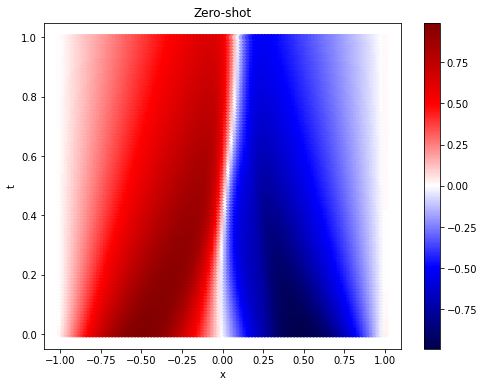

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(x, t, c=pred, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Zero-shot')
plt.colorbar()

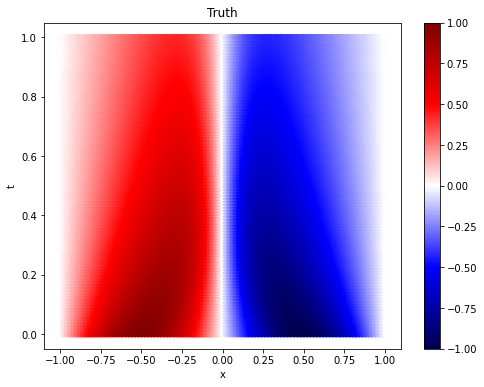

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(x, t, c=truth, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Truth')
plt.colorbar()

In [32]:
from maml import *

In [33]:
maml = MAML(5, 0.01, 0.0005, 1,2, 1, -1, 1, eqname='burgers', zero_shot=True, load=False, modelpath='models/model_ref/burgers_zs_1000_ref.data')
phi, _, inner_loss_i, inner_loss_b, inner_loss_f, inner_loss, nrmse_batch = maml._inner_loop(model_maml.state_dict(), nu, train=False)
model_adapted = deepcopy(model)
model_adapted.load_state_dict(phi)
pred_maml = model_maml(torch.Tensor(np.hstack((x, t, alpha))).to(device)).detach().cpu().numpy()
pred_maml_adapted = model_adapted(torch.Tensor(np.hstack((x, t, alpha))).to(device)).detach().cpu().numpy()

Initializing MAML-PINN model
Current device:  cuda
cuda
Zero shot mode is True
Finished initialization of MAML-PINN model
Trained model will be saved by None


In [34]:
nrmse_batch

[0.25152833621581716,
 0.2673005805758956,
 0.2797895736097293,
 0.28980103636790905,
 0.297916588578399,
 0.3045446319870659]

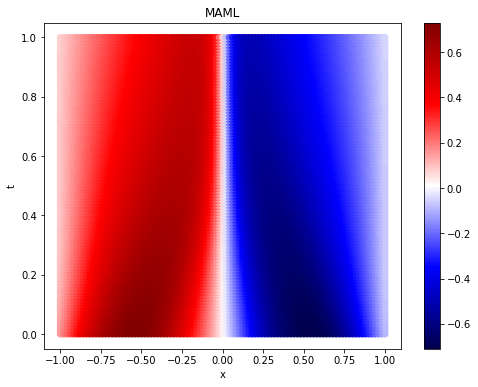

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(x, t, c=pred_maml, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.title('MAML')
plt.colorbar()

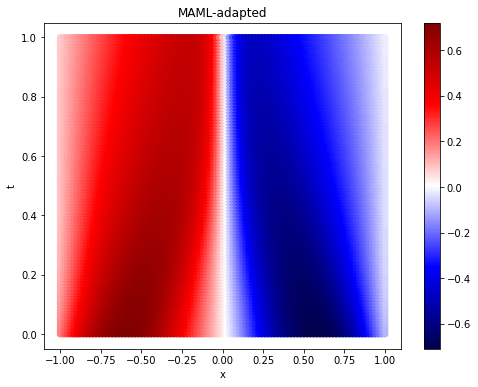

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(x, t, c=pred_maml_adapted, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.title('MAML-adapted')
plt.colorbar()

In [41]:
loss_i, loss_b, loss_f, loss, model_pinn, val_loss, val_ood_loss, nrmse, val_losses, val_ood_losses = train(epochs=5000, lr=0.01, i_size=100, b_size=100, f_size=1000, zero_shot=False, alpha_list=0.2/np.pi, low=-1, high=1, eqname='burgers')

Current device: cuda
Data generation completed
Epoch 100 | Loss_I: 0.1268 | Loss_B: 0.0424 | Loss_F: 0.0153
Epoch 200 | Loss_I: 0.0672 | Loss_B: 0.0227 | Loss_F: 0.0122
Epoch 300 | Loss_I: 0.0450 | Loss_B: 0.0152 | Loss_F: 0.0088
Epoch 400 | Loss_I: 0.0338 | Loss_B: 0.0115 | Loss_F: 0.0069
Epoch 500 | Loss_I: 0.0271 | Loss_B: 0.0092 | Loss_F: 0.0057
Epoch 600 | Loss_I: 0.0227 | Loss_B: 0.0078 | Loss_F: 0.0050
Epoch 700 | Loss_I: 0.0195 | Loss_B: 0.0067 | Loss_F: 0.0043
Epoch 800 | Loss_I: 0.0171 | Loss_B: 0.0059 | Loss_F: 0.0039
Epoch 900 | Loss_I: 0.0152 | Loss_B: 0.0053 | Loss_F: 0.0035
Epoch 1000 | Loss_I: 0.0137 | Loss_B: 0.0048 | Loss_F: 0.0032
Epoch 1100 | Loss_I: 0.0125 | Loss_B: 0.0043 | Loss_F: 0.0030
Epoch 1200 | Loss_I: 0.0115 | Loss_B: 0.0040 | Loss_F: 0.0028
Epoch 1300 | Loss_I: 0.0106 | Loss_B: 0.0037 | Loss_F: 0.0026
Epoch 1400 | Loss_I: 0.0098 | Loss_B: 0.0035 | Loss_F: 0.0024
Epoch 1500 | Loss_I: 0.0092 | Loss_B: 0.0032 | Loss_F: 0.0023
Epoch 1600 | Loss_I: 0.0086 | Lo

In [42]:
pred_pinn = model_pinn(torch.Tensor(np.hstack((x, t))).to(device)).detach().cpu().numpy()

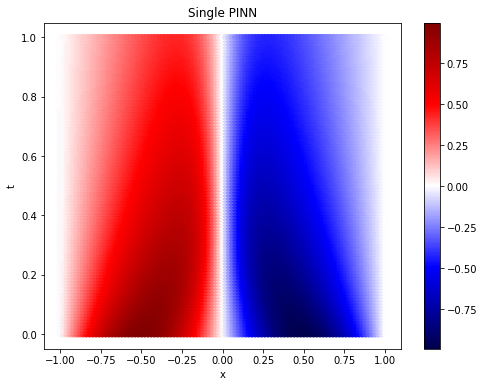

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(x, t, c=pred_pinn, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Single PINN')
plt.colorbar()

In [51]:
idx = 75
print(vt[idx])
x_025 = np.linspace(-1, 1, 101).reshape(-1, 1)
t_025 = np.full((x_025.shape), idx / 100)

pred_ = model(torch.Tensor(np.hstack((x_025, t_025, np.full((x_025.shape), nu)))).to(device)).detach().cpu().numpy()
pred_maml_ = model_maml(torch.Tensor(np.hstack((x_025, t_025, np.full((x_025.shape), nu)))).to(device)).detach().cpu().numpy()
pred_pinn_ = model_pinn(torch.Tensor(np.hstack((x_025, t_025))).to(device)).detach().cpu().numpy()
task = 0.01 / np.pi
# test_in = np.hstack((x, t, alpha))
test_in_t = np.hstack((x_025, t_025, np.full((x_025.shape), task)))

model_adapted = deepcopy(model)
model_adapted.load_state_dict(phi)
# Y2 = model_adapted(torch.Tensor(test_in).to(device)).detach().cpu().numpy()
Y2_t = model_adapted(torch.Tensor(test_in_t).to(device)).detach().cpu().numpy()

0.75


Text(0.5, 1.0, 't=0.75')

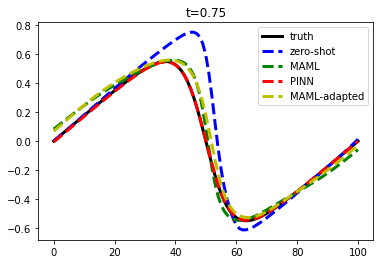

In [52]:
plt.plot(truth[idx, :], 'k', linewidth=3, label='truth')
plt.plot(pred_, 'b--', linewidth=3, label='zero-shot')
plt.plot(pred_maml_, 'g--', linewidth=3, label='MAML')
plt.plot(pred_pinn_, 'r--', linewidth=3, label='PINN')
plt.plot(Y2_t, 'y--', linewidth=3, label='MAML-adapted')
plt.legend()
plt.title('t={}'.format(vt[idx]))

In [ ]:
np.sqrt(np.sum((pred-truth.reshape(-1, 1)) ** 2) / np.sum(pred ** 2))

In [ ]:
np.mean(np.abs(pred-truth.reshape(-1, 1)))

In [ ]:
plt.scatter(x, t, c=((pred.reshape(101, 101) - truth) ** 2).reshape(-1, 1), cmap='seismic')
plt.colorbar()

In [40]:
def compute_nrmse(C, Y):
    return np.sqrt(np.sum((C-Y)**2)/np.sum(C**2))

In [ ]:
nrmse_test_zs = []
nrmse_test_maml = []
nrmse_test_maml_adapted = []
nrmse_test_pinn = []

alpha_val = np.random.uniform(low=0.005/np.pi, high=0.1/np.pi, size=5)
# beta_val = np.random.uniform(low=-1, high=1, size=10)
# alpha_val = np.hstack((np.random.uniform(low=-1.5, high=-1, size=5), np.random.uniform(low=1, high=1.5, size=5)))
# beta_val = np.hstack((np.random.uniform(low=-1.5, high=-1, size=5), np.random.uniform(low=1, high=1.5, size=5)))

for alpha in alpha_val:
    loss_i, loss_b, loss_f, loss, model_, val_loss, val_ood_loss, nrmse, _, _ = train(epochs=5000, lr=0.01, i_size=100, b_size=100, f_size=1000, zero_shot=False, alpha_list=alpha, beta_list=None, low=-1, high=1, eqname='burgers')
    vtn = 21
    vxn = 21
    test_alpha = np.full((vtn * vxn, 1), alpha)
    nu = 0.01 / np.pi
    vx = np.linspace(-1, 1, vxn)
    vt = np.linspace(0, 1, vtn)
    x, t = np.meshgrid(vx, vt)
    x = x.reshape(-1, 1)
    t = t.reshape(-1, 1)
    truth = burgers_viscous_time_exact1(nu, vxn, vx, vtn, vt).T
    Y = truth.reshape(-1, 1)
    test_in = np.hstack((x, t, test_alpha))
    test_x = np.hstack((x, t))
    test_u_ = model_(torch.Tensor(test_x).to(device))
    test_u = model(torch.Tensor(test_in).to(device))
    test_u_2 = model_maml(torch.Tensor(test_in).to(device))
    test_u_3 = model_adapted(torch.Tensor(test_in).to(device))
    C_ = test_u_.cpu().detach().numpy()
    C = test_u.cpu().detach().numpy()
    C2 = test_u_2.cpu().detach().numpy()
    C3 = test_u_3.cpu().detach().numpy()
    nrmse_test_pinn.append(compute_nrmse(C_, Y))
    nrmse_test_zs.append(compute_nrmse(C, Y))
    nrmse_test_maml.append(compute_nrmse(C2, Y))
    nrmse_test_maml_adapted.append(compute_nrmse(C3, Y))
    
mean_nrmse_pinn = np.mean(np.array(nrmse_test_pinn))                    
mean_nrmse_zs = np.mean(np.array(nrmse_test_zs))
mean_nrmse_maml = np.mean(np.array(nrmse_test_maml))
mean_nrmse_adapt_maml = np.mean(np.array(nrmse_test_maml_adapted))

std_nrmse_pinn = np.std(np.array(nrmse_test_pinn))                    
std_nrmse_zs = np.std(np.array(nrmse_test_zs))
std_nrmse_maml = np.std(np.array(nrmse_test_maml))
std_nrmse_adapt_maml = np.std(np.array(nrmse_test_maml_adapted))
    
high_nrmse_pinn = mean_nrmse_pinn + 1.96 * std_nrmse_pinn                    
high_nrmse_zs = mean_nrmse_zs + 1.96 * std_nrmse_zs
high_nrmse_maml = mean_nrmse_maml + 1.96 * std_nrmse_maml
high_nrmse_adapt_maml = mean_nrmse_adapt_maml + 1.96 * std_nrmse_adapt_maml

low_nrmse_pinn = mean_nrmse_pinn - 1.96 * std_nrmse_pinn                    
low_nrmse_zs = mean_nrmse_zs - 1.96 * std_nrmse_zs
low_nrmse_maml = mean_nrmse_maml - 1.96 * std_nrmse_maml
low_nrmse_adapt_maml = mean_nrmse_adapt_maml - 1.96 * std_nrmse_adapt_maml

Current device: cuda
Data generation completed
Epoch 100 | Loss_I: 0.1335 | Loss_B: 0.0428 | Loss_F: 0.0216
Epoch 200 | Loss_I: 0.0728 | Loss_B: 0.0241 | Loss_F: 0.0197
Epoch 300 | Loss_I: 0.0490 | Loss_B: 0.0163 | Loss_F: 0.0147
Epoch 400 | Loss_I: 0.0369 | Loss_B: 0.0123 | Loss_F: 0.0116
Epoch 500 | Loss_I: 0.0296 | Loss_B: 0.0100 | Loss_F: 0.0097
Epoch 600 | Loss_I: 0.0247 | Loss_B: 0.0084 | Loss_F: 0.0082
Epoch 700 | Loss_I: 0.0212 | Loss_B: 0.0072 | Loss_F: 0.0071
Epoch 800 | Loss_I: 0.0186 | Loss_B: 0.0063 | Loss_F: 0.0063
Epoch 900 | Loss_I: 0.0165 | Loss_B: 0.0056 | Loss_F: 0.0057
Epoch 1000 | Loss_I: 0.0149 | Loss_B: 0.0051 | Loss_F: 0.0052
Epoch 1100 | Loss_I: 0.0135 | Loss_B: 0.0047 | Loss_F: 0.0048
Epoch 1200 | Loss_I: 0.0124 | Loss_B: 0.0043 | Loss_F: 0.0044
Epoch 1300 | Loss_I: 0.0115 | Loss_B: 0.0040 | Loss_F: 0.0041
Epoch 1400 | Loss_I: 0.0107 | Loss_B: 0.0037 | Loss_F: 0.0039
Epoch 1500 | Loss_I: 0.0100 | Loss_B: 0.0035 | Loss_F: 0.0037
Epoch 1600 | Loss_I: 0.0093 | Lo

In [53]:
x = np.arange(4)
methods = ['PINN', 'zero-shot', 'MAML', 'adapted MAML']
values = [mean_nrmse_pinn, mean_nrmse_zs, mean_nrmse_maml, mean_nrmse_adapt_maml]
yerr = [(high_nrmse_pinn - low_nrmse_pinn) / np.sqrt(5), (high_nrmse_zs - low_nrmse_zs) / np.sqrt(5), (high_nrmse_maml - low_nrmse_maml) / np.sqrt(5), (high_nrmse_adapt_maml - low_nrmse_adapt_maml)/ np.sqrt(5)] 
colors = ['r', 'b', 'g', 'y']

plt.bar(x, values, color=colors, yerr=yerr, capsize=10)
plt.xticks(x, methods)
plt.yscale('log')
plt.ylabel('NRMSE')
plt.title('NRMSEs (in-distribution)')

plt.show()

NameError: name 'mean_nrmse_pinn' is not defined